In [4]:
import tensorflow as tf
import tensorflow_probability as tfp

tfm = tf.math
tfl = tf.linalg
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from tqdm.notebook import trange

%matplotlib inline
%config InlineBackend.figure_format='retina'

KLD from q to p: 112.818 nats


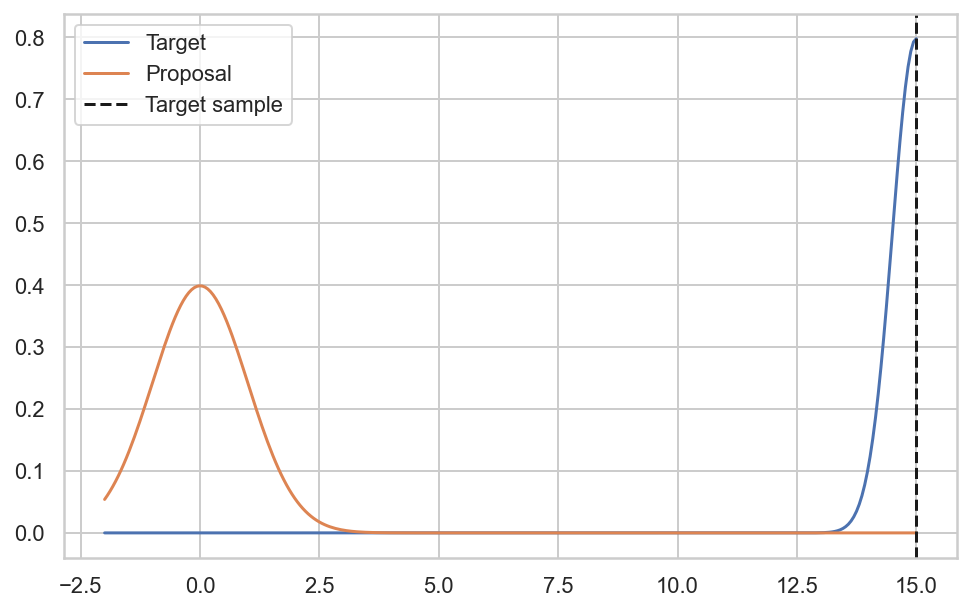

In [48]:
tf.random.set_seed(42)

q_loc = 15.
q_var = 0.25

p_loc = 0.
p_var = 1.

q = tfd.Normal(loc=q_loc, scale=tfm.sqrt(q_var))
p = tfd.Normal(loc=p_loc, scale=tfm.sqrt(p_var))

z_samp = 15.

total_kl = tfd.kl_divergence(q, p)

print(f"KLD from q to p: {total_kl:.3f} nats")

# ================================
# Plot stuff
# ================================

xs = tf.linspace(-2., 15., 300)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(xs, q.prob(xs), label="Target")
ax.plot(xs, p.prob(xs), label="Proposal")

ax.axvline(z_samp, c='k', ls='--', label="Target sample")

ax.legend()

plt.show()

# Empirical true posterior in REC

We sample $z_1, ..., z_N \sim p(z \mid \mathcal{D})$, and set $q(z) = \frac{1}{N} \sum_{n = 1}^N \delta_{z_n}(z)$.

## One sample case

If we only take a single $z_1 \sim p(z \mid \mathcal{D})$, then $q(z) = \delta_{z_1}(z)$.

In this case, we have that
$$
\begin{aligned}
    q(z \mid a_{1:k}) &= q(a_k \mid a_{1:k-1})^{-1} \delta_{z_1}(z)\prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z) \\
    &\propto \delta_{z_1}(z)\prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z)
\end{aligned}
$$
and hence, we get
$$
\begin{aligned}
    q(a_k \mid a_{1:k - 1}) &= \int p(a_k \mid a_{1:k - 1}, z) q(z \mid a_{1:k - 1}) dz \\
    &\propto \int p(a_k \mid a_{1:k - 1}, z) \delta_{z_1}(z)\prod_{i = 1}^{k - 1} p(a_i \mid a_{1:i - 1}, z) dz \\
    &= \prod_{i = 1}^k p(a_i \mid a_{1:i - 1}, z_1) \\
    &\propto p(a_k \mid a_{1:k - 1}, z_1)
\end{aligned}
$$

### Optimizing the KL
We wish to set $KL[q(a_k \mid a_{1:k - 1}) \, || \, p(a_k)]$ to $\Omega$. We note that
$$
\begin{aligned}
KL[q(a_k \mid a_{1:k - 1}) \, || \, p(a_k)] &= \mathbb{E}_{q(a_{1:k})}\left[ \log\frac{q(a_k \mid a_{1:k - 1})}{p(a_k)} \right] \\
&\approx \frac{1}{M}\sum_{m = 1}^M \mathbb{E}_{q(a_k \mid a_{1:k - 1}^{(m)})}\left[ \log\frac{q(a_k \mid a_{1:k - 1}^{(m)})}{p(a_k)} \right] \quad \text{where } a_{1:k - 1} \sim q(a_{1:k - 1})
\end{aligned}
$$

In [6]:
omega = 8.
epsilon = 0.

num_aux = int(tfm.ceil(total_kl / omega))
print(f"KL: {total_kl:.3f}, Omega: {omega}, num auxiliaries: {num_aux}")

KL: 112.818, Omega: 8.0, num auxiliaries: 15


In [7]:
def p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio):
    """
    aux_traj is a_{1:k - 1}
    remaining_var is s_{k - 1}^2
    aux_var_ratio is sigma_k^2 / s_{k - 1}^2
    """
    
    b = tf.reduce_sum(aux_traj, axis=1)
    s_k = (1. - aux_var_ratio) * remaining_var
    
    mean = (z_samp - b) * aux_var_ratio
    var = s_k * aux_var_ratio 
    
    return mean, var

In [8]:
def sample_a_traj(z_samp, aux_var_ratios, p_var, num_samples):
    
    remaining_var = p_var
    aux_traj = tf.ones([num_samples, 0])
    
    for aux_var_ratio in aux_var_ratios:
        post_aux_mean, post_aux_var = p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio)
        
        post_aux_samp = tfd.Normal(loc=post_aux_mean, scale=tfm.sqrt(post_aux_var)).sample()
        
        aux_traj = tf.concat([aux_traj, post_aux_samp[:, None]], axis=1)
        
        remaining_var = (1. - aux_var_ratio) * remaining_var
        
    return aux_traj

In [50]:
tf.random.set_seed(4)

num_mc_samples = 1000
num_opt_steps = 500
optimizer = tf.optimizers.Adam(learning_rate=3e-3)

beta = 1.

remaining_var = p_var
remaining_kl = total_kl

aux_var_ratios = tf.zeros([0])
aux_var_ratio = 1. / num_aux


aux_variances = tf.zeros([0])

for i in range(1, num_aux):
    print(f"Optimizing aux variable {i}/{num_aux - 1}!")
    print((num_aux - i - 1) * omega)
    
    aux_var_ratio = tf.Variable(aux_var_ratio)
    pbar = trange(num_opt_steps)
    for j in pbar:
        with tf.GradientTape() as tape:

            # Sample q(a_{1:k - 1})
            aux_traj = sample_a_traj(z_samp, aux_var_ratios, p_var, num_mc_samples)

            # Calculate p(a_k | a_{1:k - 1}^(m), z)
            aux_post_loc, aux_post_var = p_ak_given_traj_and_z(aux_traj, z_samp, remaining_var, aux_var_ratio)

            aux_post = tfd.Normal(loc=aux_post_loc, scale=tfm.sqrt(aux_post_var))
            aux_prior = tfd.Normal(loc=0., scale=tfm.sqrt(aux_var_ratio * remaining_var))

            aux_kl = tfd.kl_divergence(aux_post, aux_prior)

            aux_loss = (aux_kl - omega)**2
            
            remaining_kl_loss = ((remaining_kl - aux_kl) - (num_aux - i - 1) * omega)**2
            
            loss = tf.reduce_mean(remaining_kl_loss + aux_loss)

        grad = tape.gradient(loss, (aux_var_ratio,))
        optimizer.apply_gradients(zip(grad, (aux_var_ratio,)))
        
        pbar.set_description(f"Aux var ratio: {aux_var_ratio.numpy():.5f}, Loss: {loss:.5f}")
        
    aux_variance = aux_var_ratio * remaining_var
    remaining_var -= aux_variance
    remaining_kl -= tf.reduce_mean(aux_kl)
    
    aux_var_ratios = tf.concat([aux_var_ratios, aux_var_ratio[None]], axis=0)
    aux_variances = tf.concat([aux_variances, aux_variance[None]], axis=0)
    
    print(f"Final KL at iteration {i}/{num_aux - 1}: {tf.reduce_mean(aux_kl).numpy():.5f} nats.\n"
          f"Aux variance: {aux_variance.numpy():.5f}\n"
          f"Remaining KL: {remaining_kl:.5f}/{total_kl:.5f}")

Optimizing aux variable 1/14!
104.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 1/14: 8.40907 nats.
Aux variance: 0.07473
Remaining KL: 104.40908/112.81815
Optimizing aux variable 2/14!
96.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 2/14: 8.21017 nats.
Aux variance: 0.07314
Remaining KL: 96.19891/112.81815
Optimizing aux variable 3/14!
88.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 3/14: 7.99199 nats.
Aux variance: 0.07114
Remaining KL: 88.20692/112.81815
Optimizing aux variable 4/14!
80.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 4/14: 8.05034 nats.
Aux variance: 0.07158
Remaining KL: 80.15659/112.81815
Optimizing aux variable 5/14!
72.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 5/14: 8.05325 nats.
Aux variance: 0.07114
Remaining KL: 72.10334/112.81815
Optimizing aux variable 6/14!
64.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 6/14: 7.97860 nats.
Aux variance: 0.07088
Remaining KL: 64.12474/112.81815
Optimizing aux variable 7/14!
56.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 7/14: 7.89584 nats.
Aux variance: 0.07031
Remaining KL: 56.22890/112.81815
Optimizing aux variable 8/14!
48.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 8/14: 8.08034 nats.
Aux variance: 0.07142
Remaining KL: 48.14857/112.81815
Optimizing aux variable 9/14!
40.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 9/14: 7.86723 nats.
Aux variance: 0.06938
Remaining KL: 40.28133/112.81815
Optimizing aux variable 10/14!
32.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 10/14: 7.84343 nats.
Aux variance: 0.06895
Remaining KL: 32.43790/112.81815
Optimizing aux variable 11/14!
24.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 11/14: 7.93877 nats.
Aux variance: 0.06901
Remaining KL: 24.49914/112.81815
Optimizing aux variable 12/14!
16.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 12/14: 7.77311 nats.
Aux variance: 0.06762
Remaining KL: 16.72603/112.81815
Optimizing aux variable 13/14!
8.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 13/14: 7.53253 nats.
Aux variance: 0.06572
Remaining KL: 9.19350/112.81815
Optimizing aux variable 14/14!
0.0


  0%|          | 0/500 [00:00<?, ?it/s]

Final KL at iteration 14/14: 7.40409 nats.
Aux variance: 0.06071
Remaining KL: 1.78942/112.81815


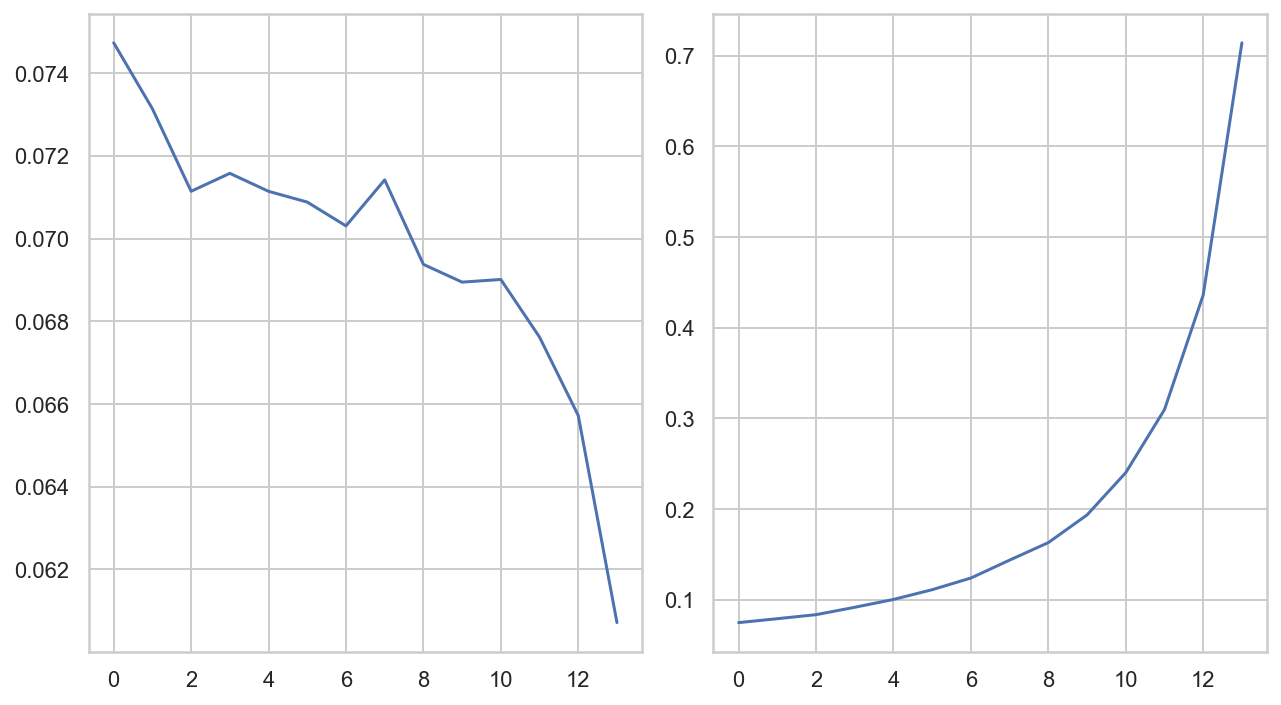

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

axes[0].plot(aux_variances)
axes[1].plot(aux_var_ratios)

fig.tight_layout()
plt.show()

In [52]:
p_var - tf.reduce_sum(aux_variances)

<tf.Tensor: shape=(), dtype=float32, numpy=0.024279118>

In [53]:
aux_variances

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([0.07473423, 0.07313889, 0.07114319, 0.07157691, 0.07114197,
       0.07088171, 0.07030594, 0.07141884, 0.06937507, 0.06894591,
       0.06901029, 0.06761638, 0.06572011, 0.06071148], dtype=float32)>